In [6]:
import monai
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    Spacingd,
    RandWeightedCrop,
    RandRotate,
    RandFlip,
    Rand3DElasticd,
    RandRotated,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandFlipd)
import tqdm
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, DataLoader, PersistentDataset
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob
from monai.networks.blocks import Convolution
from monai.networks.nets import Discriminator, Generator
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 
from pytorchtools import EarlyStopping



In [7]:
gad_t1= sorted(glob('/home/fogunsan/scratch/degad/derivatives/passing_dataset/*/*_acq-gad_resampled_T1w.nii.gz'))# gad images who's corresponding nongad images underwent a rigid transform
nongad_t1= sorted(glob('/home/fogunsan/scratch/degad/derivatives/normalized_fcm/*/*_acq-nongad_normalized_fcm.nii.gz')) # nongad images which underwent a rigid transform and underwent fcm normalization
image_dict = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(gad_t1,nongad_t1)] #creates list of dictionaries, with gad and nongad images labelled
print(len(image_dict))
train_files, validate_files, test_files = image_dict[0:33], image_dict[33:42], image_dict[42:47] #creates a list of dictionaries for each set (training, val, testing), with keys of gad and nongad in each index 

47


In [9]:
## now caching before and after patching
num_train_files = len(train_files)
num_validate_files = len(validate_files)
num_patches =1500 #patches per image
batch_size = 5
date = "May21" # set to current day to not overwrite previous models
training_steps = int(num_train_files * num_patches / batch_size) # number of training steps per epoch
validation_steps = int(num_validate_files * num_patches / batch_size) # number of validation steps per epoch
load_images= Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys = ["image"], minv=0.0, maxv=1.0)])# applying min max normalization only on gad images
    
train_imgs_cache = CacheDataset(data=train_files, transform=load_images, cache_rate=1.0, num_workers = 1) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_imgs_cache = CacheDataset(data=validate_files, transform=load_images, cache_rate=1.0,num_workers =1)

patching_func= RandCropByPosNegLabeld( # gonna use this function to create patches
            keys = ["image", "label"],
            label_key = "image",
            spatial_size=(32,32,32),
            pos = 1,
            neg = 0.01, # 1
            num_samples= num_patches# CHANGE BACK TO 5000
        )
patch_transforms = Compose(
    RandRotated(keys =["image", "label"], range_x = 0.8, range_y = 0.8, range_z = 0.8, prob = 0.4), 
    RandFlipd(keys =["image", "label"], prob = 0.2, spatial_axis=1))
   # Rand3DElasticd(keys =["image", "label"], sigma_range = (0.5,1), magnitude_range = (0.1, 0.3), prob=0.3, shear_range=[0.1, -0.05, 0.0, 0.0, 0.0, 0.0], scale_range=0.5, padding_mode= "zeros")
# flipping along y-axis (horizontally), using small SD range for blurring kernel for the warp, 
train_patches_dataset = PatchDataset(data = train_imgs_cache, patch_func=patching_func, samples_per_image=num_patches, transform= patch_transforms)
validate_patches_dataset = PatchDataset(data = validate_imgs_cache, patch_func=patching_func, samples_per_image=num_patches, transform= patch_transforms) 

train_patches_dataset = CacheDataset(data=train_patches_dataset,cache_rate=1.0, num_workers =1, copy_cache= True) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_patches_dataset = CacheDataset(data=validate_patches_dataset, cache_rate=1.0, num_workers =1, copy_cache=True)



Loading dataset: 100%|██████████| 67/67 [00:14<00:00,  4.78it/s]


In [4]:
CNN=UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32,64,128,256,512,512,512),
            strides=(2, 2, 2, 2,1,1,1),
            dropout= 0.2,
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
CNN.apply(monai.networks.normal_init)
CNN_model = CNN.to(device)


In [5]:
import time
learning_rate = 2e-4
betas = (0.5, 0.999)
cnn_opt = torch.optim.Adam(CNN_model.parameters(), lr = learning_rate, betas=betas)

patience = 12# epochs it will take for training to terminate if no improvement
early_stopping = EarlyStopping(patience=patience, verbose=True, path = f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint.pt')
start = time.time() # initializing variable to calculate training time

max_epochs = 1000 # max total iterations over entire training set
#root_mean_squared = MeanSquaredError(squared = False).to(device) #rmse metric calculated at the end of each epoch for training and val
mean_abs_error = torch.nn.L1Loss().to(device)

mae_val = [0] # list of validation loss calculated at the end of each epoch
epoch_loss_values = [0] # list of training loss calculated at the end of each epoch

train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validate_patches_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(max_epochs):
    CNN_model.train() # setting model to training mode
    epoch_loss = 0 # total traininig loss in an epoch
    progress_bar(
            index=epoch+1, # displays what step we are of current epoch, our epoch number, training (rmse loss) 
            count = max_epochs, 
            desc= f"epoch {epoch + 1}, training mae loss: {epoch_loss_values[-1]:.4f}, validation mae metric: {mae_val[-1]:.4f}",
            newline = True ) # progress bar to display current stage in training
    for i,train_batch in enumerate(train_loader): # iterating through dataloader
        gad_images = train_batch['image'].cuda()# gad images of batch
        nongad_images = train_batch['label'].cuda() # nongad images of batch
        cnn_opt.zero_grad()
        degad_images = CNN_model(gad_images) # feeding CNN with gad images
        train_loss= mean_abs_error(degad_images, nongad_images)
        train_loss.backward()
        cnn_opt.step()
        epoch_loss += train_loss.item() # adding loss for this batch to the total training loss for this epoch
    avg_training_loss = epoch_loss / training_steps
    epoch_loss_values.append(avg_training_loss) # append total epoch loss divided by the number of training steps in epoch to loss list
    CNN_model.eval() #setting model to evaluation mode for training
    with torch.no_grad(): #we do not update weights/biases in validation training, only used to assess current state of model
        #mean_abs_error.reset() # resetting validation metric state for every epoch
        mae_total_epoch = 0 # mean squared error for the entire epoch
        for i,val_batch in enumerate(val_loader): # iterating through dataloader
            gad_images =val_batch["image"].cuda()# batch with gad images
            nongad_images = val_batch["label"].cuda() # batch with nongad images
            degad_images = CNN_model(gad_images)
            val_loss = mean_abs_error(degad_images, nongad_images)
            mae_total_epoch += val_loss # adding val mse of this batch to total val epoch mse
        avg_val_mae = mae_total_epoch.item()/validation_steps
        mae_val.append(avg_val_mae) # dividing total mse in this epoch by the number of batches -> add to list of epoch mse
        early_stopping(avg_val_mae, CNN_model) # early stopping is based on the average validation mse for an epoch, keeps track of last best model
        
    if early_stopping.early_stop:
        print("Early stopping") # stops early if validation mae has not improved for 10 epochs
        break

end = time.time()
time = end - start
print(time)


1/1000 epoch 1, training mae loss: 0.0000, validation mae metric: 0.0000 [                              ]
Validation loss decreased (inf --> 0.214018).  Saving model ...
2/1000 epoch 2, training mae loss: 0.3734, validation mae metric: 0.2140 [                              ]


KeyboardInterrupt: 

In [7]:
with open (f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/model_stats.txt', 'w') as file:  
    file.write(f'training time: {time}\n')  
    file.write(f'training loss: {epoch_loss_values[-1]} validation loss: {mae_val[-1]}')

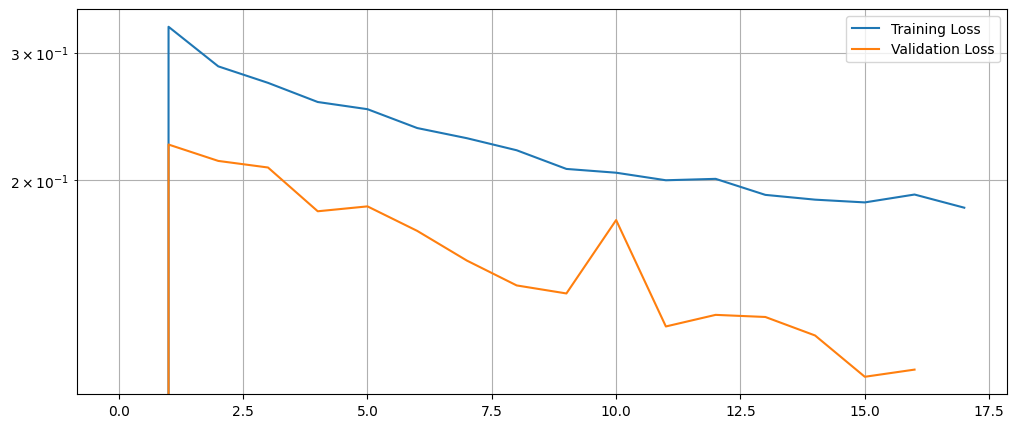

In [8]:
plt.figure(figsize=(12, 5))
plt.semilogy(list(range(len(epoch_loss_values))), epoch_loss_values, label="Training Loss")
plt.semilogy(list(range(len(mae_val))), mae_val , label="Validation Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/lossfunction.png')
